#Import the data

In [0]:
#  !pip install yfinance

In [4]:
import yfinance as yf

ticker = 'AAPL'
stock_info = yf.Ticker(ticker)
hist = stock_info.history(period='max')

hist.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1980-12-12,0.41,0.41,0.41,0.41,117258400,0.0,0.0
1980-12-15,0.39,0.39,0.39,0.39,43971200,0.0,0.0
1980-12-16,0.36,0.36,0.36,0.36,26432000,0.0,0.0
1980-12-17,0.37,0.37,0.37,0.37,21610400,0.0,0.0
1980-12-18,0.38,0.38,0.38,0.38,18362400,0.0,0.0


#Check for stationarity

In [0]:
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import pandas as pd

def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.figure(figsize=(18, 8))
    plt.plot(timeseries, color='blue', label="Original")
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend()
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
   
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
   
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


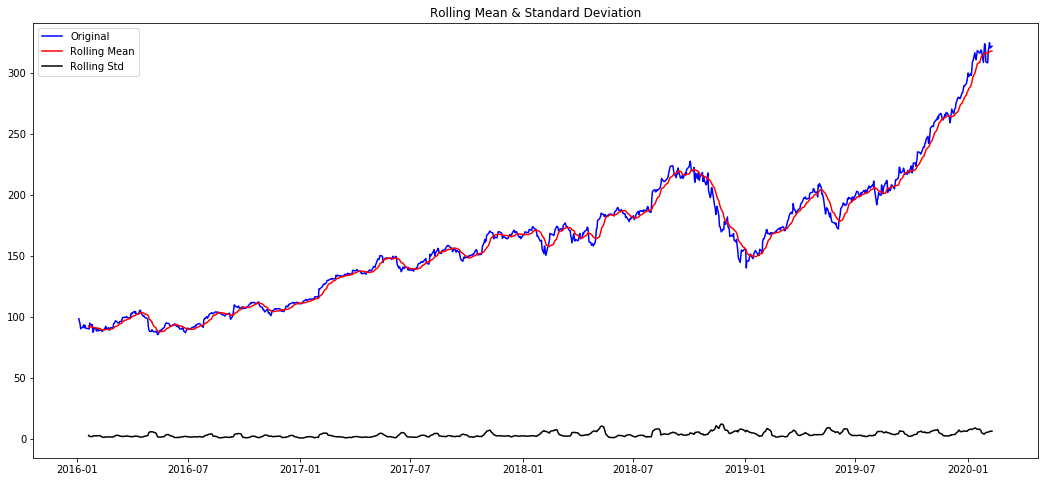

Results of Dickey-Fuller Test:
Test Statistic                    1.142333
p-value                           0.995562
#Lags Used                        7.000000
Number of Observations Used    1025.000000
Critical Value (1%)              -3.436746
Critical Value (5%)              -2.864364
Critical Value (10%)             -2.568274
dtype: float64


In [6]:
ts = hist['2016':].Close
test_stationarity(ts)

This is not stationary because :
*   Mean is increasing even though the std is small.
*   The p-value is > critical value of 0.05.

#Decompose the series into trend, seasonal and residual components

In [0]:
from statsmodels.tsa.seasonal import seasonal_decompose

def decompose(ts, freq=253):
  decomp = seasonal_decompose(ts, freq=freq)
  trend = decomp.trend
  seasonal = decomp.seasonal
  residual = decomp.resid

  plt.figure(figsize=(16,8))
  plt.subplot(411)
  plt.plot(ts, label="Original")
  plt.legend(loc='upper left')
  plt.subplot(412)
  plt.plot(trend, label="Trend")
  plt.legend(loc='upper left')
  plt.subplot(413)
  plt.plot(seasonal, label="Seasonality")
  plt.legend(loc='upper left')
  plt.subplot(414)
  plt.plot(residual, label="Residuals")
  plt.legend(loc='upper left')
  plt.tight_layout()
  return trend, seasonal, residual

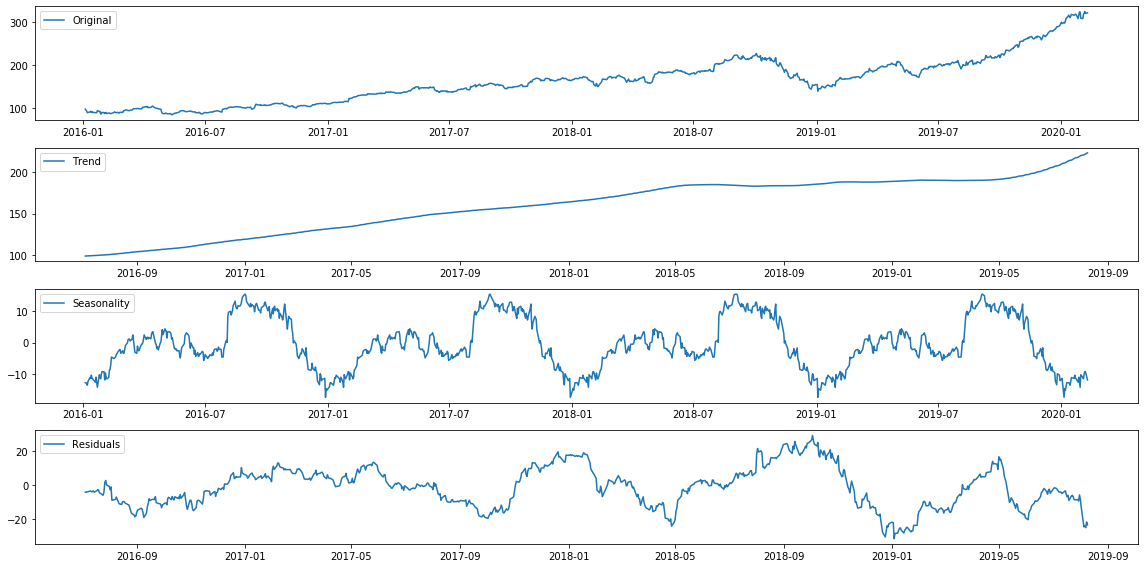

In [8]:
import numpy as np

trend, seasonal, residual_org = decompose(ts)
residual = residual_org.dropna()


#Test stationarity of the residual

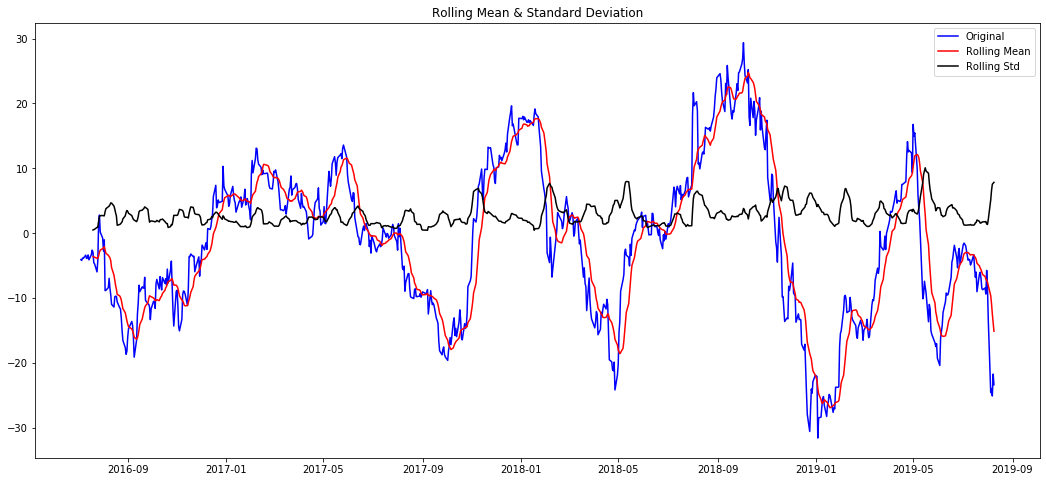

Results of Dickey-Fuller Test:
Test Statistic                  -2.870923
p-value                          0.048835
#Lags Used                       7.000000
Number of Observations Used    773.000000
Critical Value (1%)             -3.438838
Critical Value (5%)             -2.865286
Critical Value (10%)            -2.568765
dtype: float64


In [9]:
test_stationarity(residual)

> ### Now we see that the p-value is < 0.05 our significant value. Meaning that our series has a 95.8% chance of being stationary.
> ### Also even though there is variance on the rolling values, there is no discernable trend.



#Lets try to get even better results by taking the difference between time steps of the residual

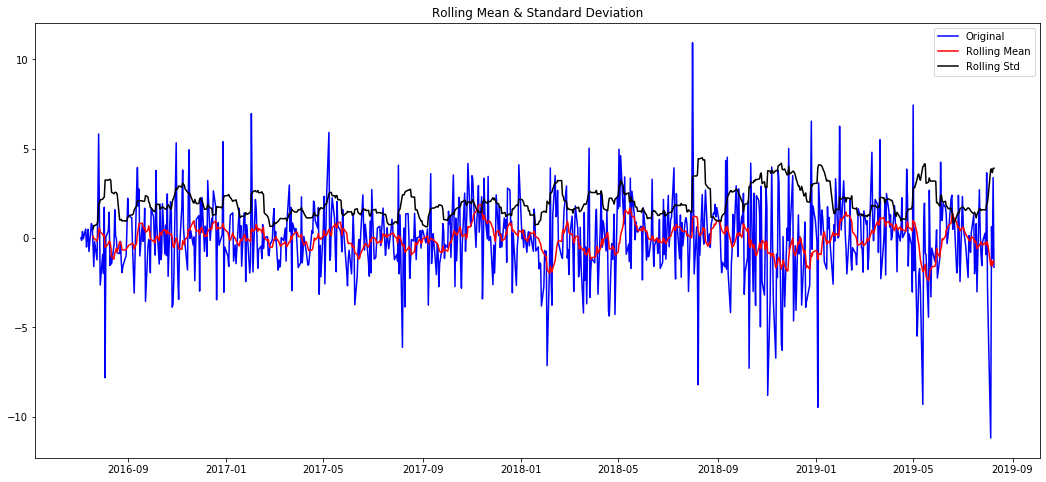

Results of Dickey-Fuller Test:
Test Statistic                 -26.500468
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    780.000000
Critical Value (1%)             -3.438761
Critical Value (5%)             -2.865253
Critical Value (10%)            -2.568747
dtype: float64


In [10]:
residual_diff = residual.diff()
residual_diff = residual_diff.fillna(value=0)
test_stationarity(residual_diff)

#Determining the autocorrelation between timesteps


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


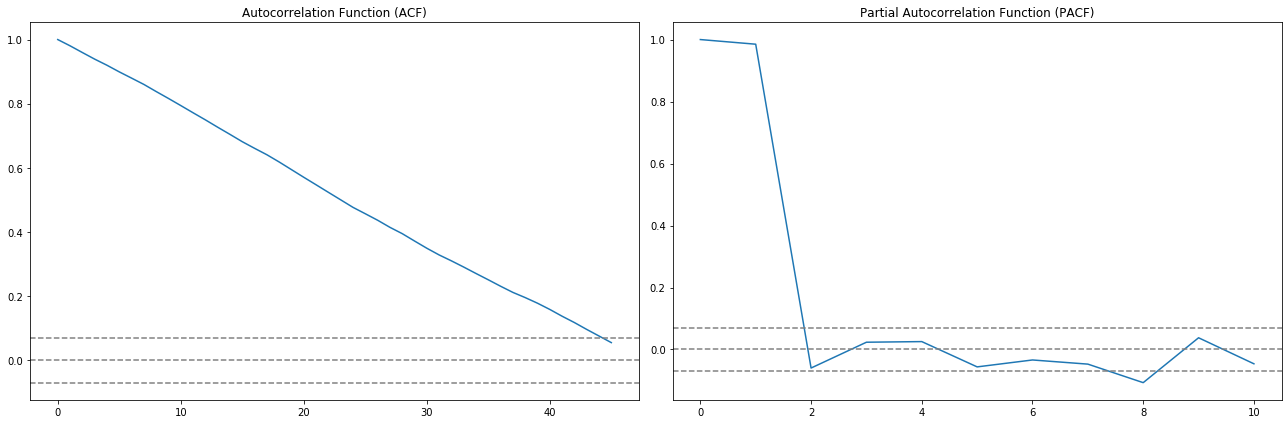

In [11]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import acf, pacf

def autocorrelate(acf_var, lag1=10, lag2=10):
  lag_acf = acf(acf_var, nlags=lag1)
  lag_pacf = pacf(acf_var, nlags=lag2, method='ols')

  plt.figure(figsize=(18, 6))
  # Plot ACF
  plt.subplot(121)
  plt.plot(lag_acf)
  plt.axhline(y=0, linestyle='--', color='gray')
  plt.axhline(y=-1.96/np.sqrt(len(acf_var)), linestyle='--', color='gray')
  plt.axhline(y=1.96/np.sqrt(len(acf_var)), linestyle='--', color='gray')
  plt.title("Autocorrelation Function (ACF)")

  # Plot PACF
  plt.subplot(122)
  plt.plot(lag_pacf)
  plt.axhline(y=0, linestyle='--', color='gray')
  plt.axhline(y=-1.96/np.sqrt(len(acf_var)), linestyle='--', color='gray')
  plt.axhline(y=1.96/np.sqrt(len(acf_var)), linestyle='--', color='gray')
  plt.title("Partial Autocorrelation Function (PACF)")
  plt.tight_layout()

autocorrelate(residual, 45)

###The ACF crosses the upper confidence interval at the value of 45. hence q = 45

###The PACF value crosses the confidence interval at the value of 2. hence p = 2



#Autocorrelate the first order residual difference

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


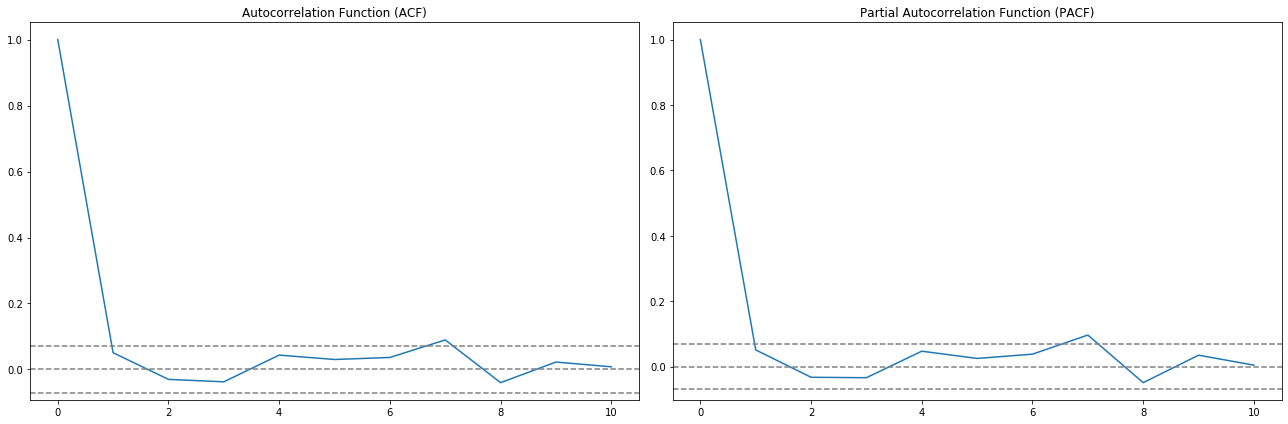

In [12]:
autocorrelate(residual_diff)

# Predicting the series
> ## AR model without differentiation


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Text(0.5, 1.0, 'RSS: 2438.2056')

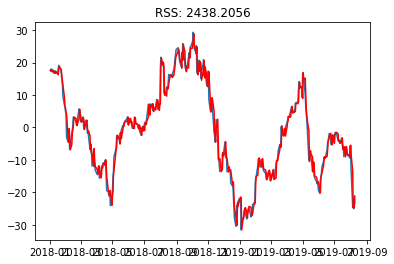

In [13]:
p = 2
d = 0
q = 45

model_var = residual
model = ARIMA(model_var, order=(p, d, 0))
results_AR = model.fit(disp=0)
plt.plot(model_var['2018':])
plt.plot(results_AR.fittedvalues['2018':], color='red')
plt.title('RSS: %.4f' % sum((results_AR.fittedvalues['2018':]-model_var['2018':])**2))




> ## AR model with differentiation



/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Text(0.5, 1.0, 'RSS: 3598.0359')

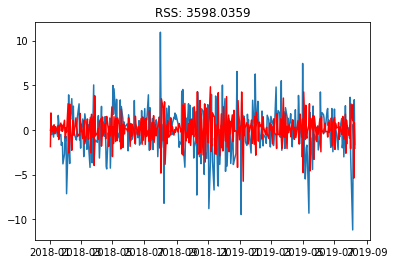

In [20]:
p = 1
d = 1
q = 1

model_var = residual_diff
model = ARIMA(model_var, order=(p, d, 0))
results_AR = model.fit(disp=0)
plt.plot(model_var['2018':])
plt.plot(results_AR.fittedvalues['2018':], color='red')
plt.title('RSS: %.4f' % sum((results_AR.fittedvalues['2018':]-model_var['2018':])**2))


> ## MA Model



/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Text(0.5, 1.0, 'RSS: 5254.4933271145')

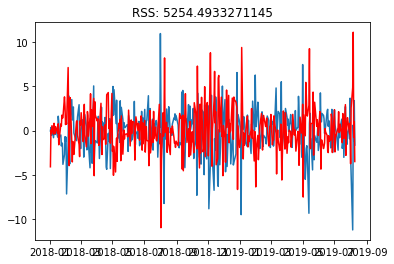

In [14]:
model_var = residual_diff
model = ARIMA(model_var, order=(0, 1, 1))
results_MA = model.fit()
plt.plot(model_var['2018':])
plt.plot(results_MA.fittedvalues['2018':], color='red')
plt.title('RSS: %.10f' % sum((results_MA.fittedvalues['2018':]-model_var['2018':])**2))



>## Arima Model



/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Text(0.5, 1.0, 'RSS: 4989.6521323777')

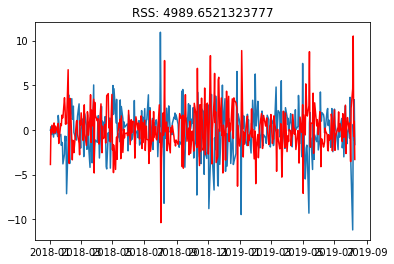

In [15]:
model = ARIMA(model_var, order=(1, 1, 1))
results_ARIMA = model.fit(disp=0)
plt.plot(model_var['2018':])
plt.plot(results_ARIMA.fittedvalues['2018':], color='red')
plt.title('RSS: %.10f' % sum((results_ARIMA.fittedvalues['2018':]-model_var['2018':])**2))

### In this case the AR model gives us the best RSS value

#Convert predictions to original scale


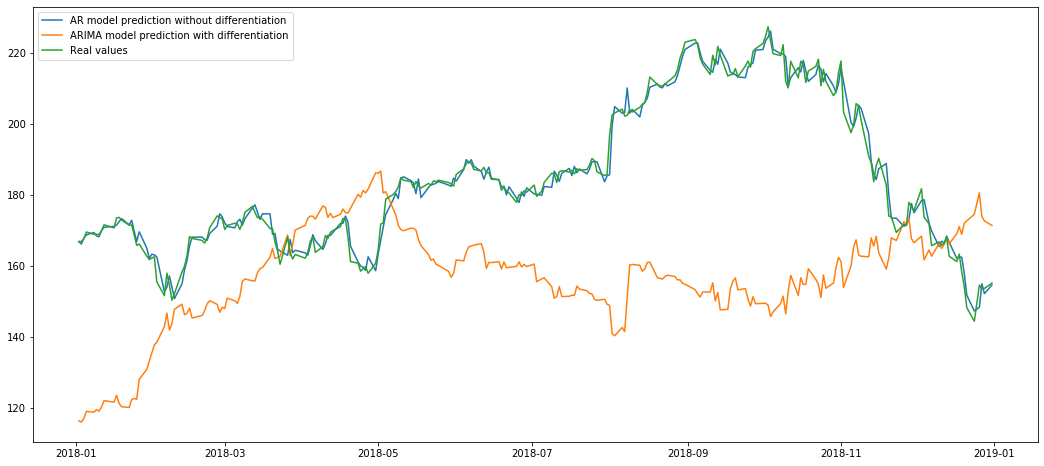

In [19]:

def undiff(base, series_diff):
  series_diff[0] = base
  undiff = series_diff.cumsum()
  return pd.Series(undiff, index=series_diff.index)

AR_pred = results_AR.fittedvalues + trend + seasonal
ARIMA_pred = undiff(residual[0], results_ARIMA.fittedvalues) + trend + seasonal 

plt.figure(figsize=(18, 8))
plt.plot(AR_pred['2018'], label="AR model prediction without differentiation")
plt.plot(ARIMA_pred['2018'], label="ARIMA model prediction with differentiation")
plt.plot(ts['2018'], label="Real values")
plt.legend()
plt.show()

##We can conclude that the AR model without differentiation performed better than the other models.